## Poly Interview -- Keanu Spies
keanuspies@gmail.com

See `SUBMISSION_README.md` for a full break-down! Thanks!

In [21]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib
import os
import numpy as np

# inspect these files for details
from data import display_batch, FilterDataset
from model import DoubleFilter, SingleFilter, SingleFilterNoNorm

batch_sz = 64
dtype = torch.float
device = torch.device("mps") # Mac M1 chip
transform = transforms.Compose([transforms.ToTensor()])

### 0. Data handling

Create datasets and dataloaders fro training. The start of this cell has a few options allowing for choice of kernel, and whether or not to normalize/double this filter. 

In [40]:
# which filter to apply, uncomment desired filter
filter = np.random.uniform(-2, 2, size=(3,3)) # random
filter_name = 'random'

# filter = [[1, 0, -1], [2, 0, -2], [1, 0, -1]] # sobel
# filter_name = 'sobel'

# 'double' applies two parallel filters a la sobel operation
# 'single' will apply only one filter
filter_type = 'single' 

# whether or not to normalize the filter after it is applied
normalize = False
if  not normalize: SingleFilter = SingleFilterNoNorm

# log file
results_dir = './results/' + filter_name + '_' + filter_type + ('_normalized' if normalize else '_not_normalized')
if not os.path.exists(results_dir):
    os.mkdir(results_dir)
log = open(results_dir + '/log.txt', 'w')
description_log = open(results_dir + '/desciption.txt', 'w')

# datasets
train_data = FilterDataset("./tiny-imagenet-200/train", filter, filter_type, normalize, transform)
valid_data = FilterDataset("./tiny-imagenet-200/val", filter, filter_type, normalize, transform)
test_data = FilterDataset("./tiny-imagenet-200/test", filter, filter_type, normalize, transform)

# dataloaders
train_loader = DataLoader(train_data, batch_size=batch_sz, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_sz)
test_loader = DataLoader(test_data, batch_size=batch_sz)

Let's visualize the filters we've applied

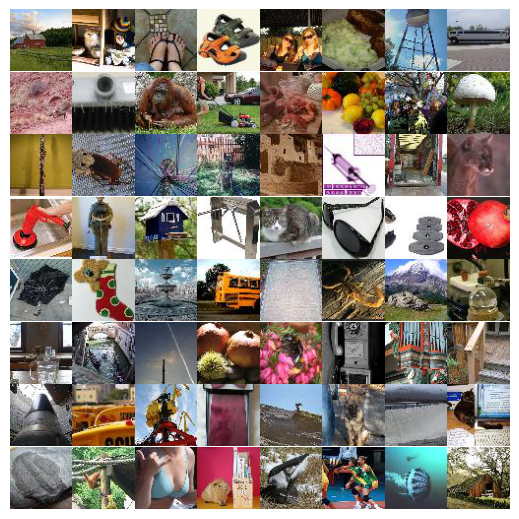

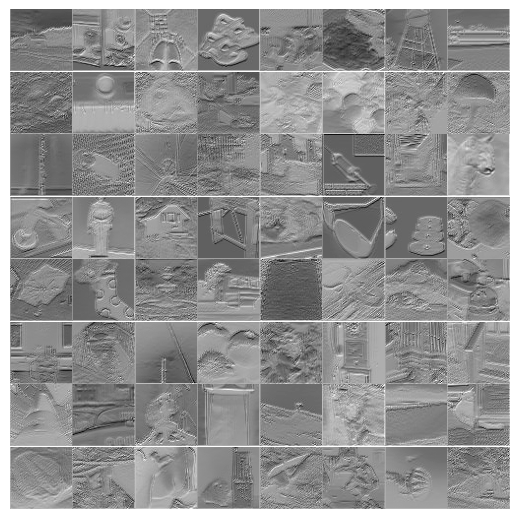

In [41]:
data_iter = iter(train_loader)
img, f_img = next(data_iter)
display_batch(img) ; display_batch(f_img, gray=True)

In [42]:
print(filter)
print(filter_type)

[[ 1.86831086  1.59904349 -1.04598831]
 [-1.31200826 -1.92325377  0.9636719 ]
 [-1.68997809  1.71946519 -1.75648337]]
single


### 1. Training

We can chose the type of filter we want to train based on whether this was a single fiter or two perpendicular (here called double) filters. 

In [43]:
# network to use
net = DoubleFilter() if filter_type == 'double' else SingleFilter()
net = net.to(device)
print(net)
print('Network Architecture',net, file=description_log)

SingleFilterNoNorm(
  (conv_layer): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


Now we can train this model to learn this filter based on the image outputs

In [44]:
# training
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

# track train and val loss
train_losses = []
valid_losses = []
for epoch in range(1):
    print('epoch {}'.format(epoch)); print('epoch {}'.format(epoch), file=log)
    loss = 0.0 
    for i, (img, f_img) in enumerate(train_loader):
        
        # sobel filter is on grayscale of an image 
        # (see: https://docs.opencv.org/3.4/d2/d2c/tutorial_sobel_derivatives.html
        gray_img = transforms.Grayscale()(img)

        optimizer.zero_grad()

        # forward
        out_img = net(gray_img)

        # backward
        loss = criterion(out_img, f_img)
        loss.backward()
        optimizer.step()

        # log 
        loss += loss.item()
        if i % 100  == 0:
            print(i, ' loss: {}'.format(loss)); print(i, ' loss: {}'.format(loss), file=log)

            with torch.no_grad():
                net.eval()
                val_loss = 0.0 
                for j, (img, f_img) in enumerate(valid_loader):
                    gray_img = transforms.Grayscale()(img)
                    out_img = net(gray_img)
                    this_loss = criterion(out_img, f_img)
                    val_loss += this_loss.item()

                # keep track of losses 
                train_losses.append((loss/(i+1)).item())
                valid_losses.append(val_loss/(j+1))

            net.train()
            loss = 0.0 


epoch 0
0  loss: 0.9625810384750366
100  loss: 0.5527609586715698
200  loss: 0.3859620690345764
300  loss: 0.2740784287452698
400  loss: 0.19562289118766785
500  loss: 0.11192431300878525
600  loss: 0.05504574626684189
700  loss: 0.02482466585934162
800  loss: 0.015921439975500107
900  loss: 0.007934287190437317
1000  loss: 0.004667578265070915
1100  loss: 0.011924813501536846
1200  loss: 0.00522356852889061
1300  loss: 0.0008846883429214358
1400  loss: 0.002245570532977581
1500  loss: 0.020699847489595413


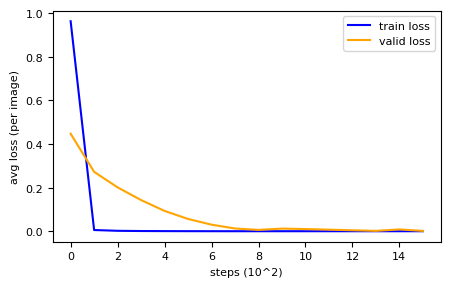

In [45]:
matplotlib.rcParams.update({'font.size': 8})
plt.figure(figsize=(5, 3))
plt.plot(train_losses, color='blue', label='train loss')
plt.plot(valid_losses, color='orange', label='valid loss')
plt.xlabel('steps (10^2)')
plt.ylabel('avg loss (per image)')
plt.legend()
plt.savefig(results_dir + '/train_val_graph.png')
plt.show()

### 2. Results on the test set

First we can compare the resulting images of the original, the filter, and the output

original


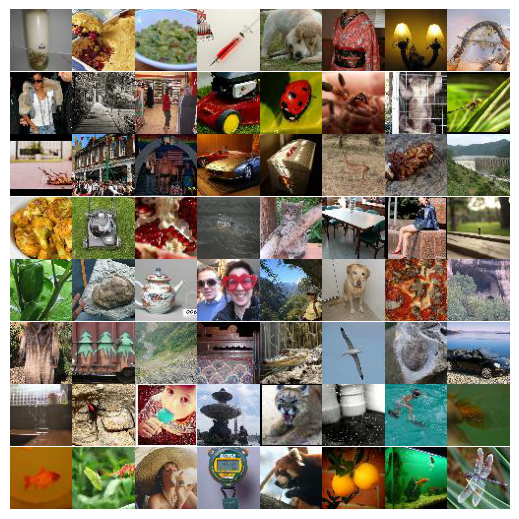

filter


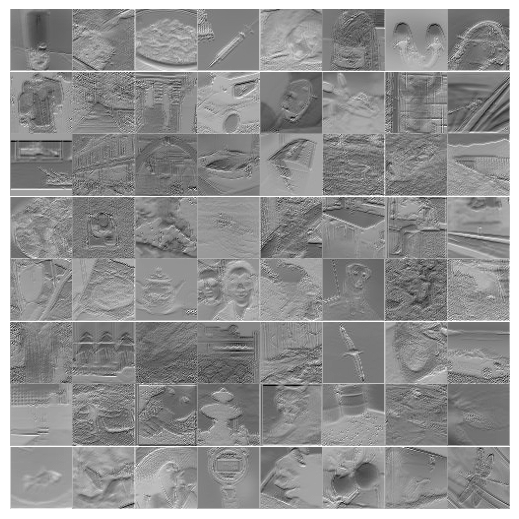

trained filter


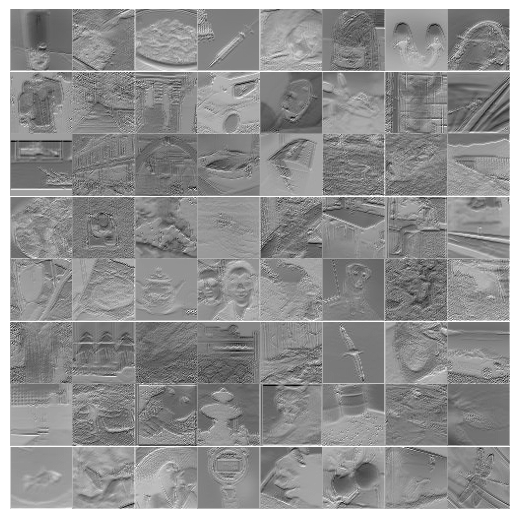

In [46]:
data_iter = iter(test_loader)
img, f_img = next(data_iter)
gray_img = transforms.Grayscale()(img)

print('original')
display_batch(img, save_fn=results_dir + '/test_imgs.png')

print('filter')
display_batch(f_img, gray=True, save_fn=results_dir +  '/test_filtered_imgs.png')

print('trained filter')
display_batch(net(gray_img), gray=True, save_fn=results_dir +  '/test_trained_net_out.png')

Lets also compare the learned filter weights to the filter applied

In [47]:
print('Learned filter:')
print('Learned filter:', file = description_log)
print(net.conv_layer.weight)
print(net.conv_layer.weight, file=description_log)

print('\n Applied Filter')
print('\n Applied Filter', file = description_log)
if filter_type == 'double':
    print('[', torch.tensor(filter)); print(torch.tensor(filter).T,']')
    print('[', torch.tensor(filter), file=description_log); print(torch.tensor(filter).T,']', file=description_log)
else: 
    print(torch.tensor(filter))
    print(torch.tensor(filter), file=description_log)

Learned filter:
Parameter containing:
tensor([[[[ 1.8674,  1.5981, -1.0469],
          [-1.3129, -1.9242,  0.9627],
          [-1.6909,  1.7185, -1.7574]]]], device='mps:0', requires_grad=True)

 Applied Filter
tensor([[ 1.8683,  1.5990, -1.0460],
        [-1.3120, -1.9233,  0.9637],
        [-1.6900,  1.7195, -1.7565]], dtype=torch.float64)


Some final cleanup :)

In [48]:
log.close()
description_log.close()
torch.save(net.state_dict(), results_dir + '/model_state_dict.pt')